<a href="https://colab.research.google.com/github/amelliaaas/TugasTKC_282-305/blob/main/Histogram_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

hi_color_correction

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Covid19-dataset/test/Covid

/content/drive/MyDrive/Covid19-dataset/test/Covid


ini kan bagian buat mindah direktori ke covid19-dataset

In [15]:
!ls /content/drive/MyDrive/Covid19-dataset

test  train


yang isinya ada test dan train

In [3]:
# import the necessary packages
from imutils.perspective import four_point_transform
from skimage import exposure
import matplotlib.pyplot as plt
import numpy as np
import argparse
import imutils
import cv2

In [4]:
def plt_imshow(title, image):
    # convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

In [5]:
def find_color_card(image):
	# load the ArUCo dictionary, grab the ArUCo parameters, and
	# detect the markers in the input image
	arucoDict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_ARUCO_ORIGINAL)
	arucoParams = cv2.aruco.DetectorParameters_create()
  

  

	(corners, ids, rejected) = cv2.aruco.detectMarkers(image,
		arucoDict, parameters=arucoParams)
	# print(image)

	# try to extract the coordinates of the color correction card
	try:
		# otherwise, we've found the four ArUco markers, so we can
		# continue by flattening the ArUco IDs list
    
		# print(ids)
		ids = ids.flatten()
		# print(ids)

		# extract the top-left marker
		i = np.squeeze(np.where(ids == 923))
		topLeft = np.squeeze(corners[i])[0]
    
		print(topLeft)

		# extract the top-right marker
		i = np.squeeze(np.where(ids == 1001))
		topRight = np.squeeze(corners[i])[1]

		# extract the bottom-right marker
		i = np.squeeze(np.where(ids == 241))
		bottomRight = np.squeeze(corners[i])[2]

		# extract the bottom-left marker
		i = np.squeeze(np.where(ids == 1007))
		bottomLeft = np.squeeze(corners[i])[3]

	# we could not find color correction card, so gracefully return
	except Exception as ex:
		print(ex)
		return None

	# build our list of reference points and apply a perspective
	# transform to obtain a top-down, birds-eye-view of the color
	# matching card
	cardCoords = np.array([topLeft, topRight,
		bottomRight, bottomLeft])
	card = four_point_transform(image, cardCoords)

	# return the color matching card to the calling function
	return card

In [7]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
    "reference": "0100.jpeg",
    "input": "0100.jpeg"
}

[INFO] loading images...


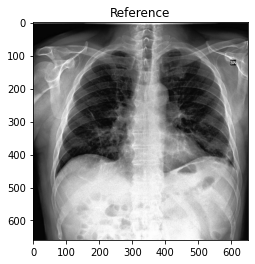

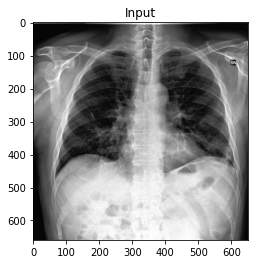

In [8]:
# load the reference image and input images from disk
print("[INFO] loading images...")
ref = cv2.imread(args["reference"])
image = cv2.imread(args["input"])

# resize the reference and input images
# ref = imutils.resize(ref, width=600)
# image = imutils.resize(image, width=600)

# display the reference and input images to our screen
plt_imshow("Reference", ref)
plt_imshow("Input", image)

In [9]:
# find the color matching card in each image
print("[INFO] finding color matching cards...")
refCard = find_color_card(ref)
imageCard = find_color_card(image)
# print(image)

# if the color matching card is not found in either the reference
# image or the input image, gracefully exit
if refCard is None or imageCard is None:
	print("[INFO] could not find color matching card in both images")

[INFO] finding color matching cards...
'NoneType' object has no attribute 'flatten'
'NoneType' object has no attribute 'flatten'
[INFO] could not find color matching card in both images


In [ ]:
# show the color matching card in the reference image and input image,
# respectively
plt_imshow("Reference Color Card", refCard)
plt_imshow("Input Color Card", imageCard)

# apply histogram matching from the color matching card in the
# reference image to the color matching card in the input image
print("[INFO] matching images...")
imageCard = exposure.match_histograms(imageCard, refCard,
	multichannel=True)

# show our input color matching card after histogram matching
plt_imshow("Input Color Card After Matching", imageCard)

hi_detect_low_contrast

In [11]:
# import the necessary packages
from skimage.exposure import is_low_contrast
from imutils.paths import list_images
import matplotlib.pyplot as plt
import numpy as np
import argparse
import imutils
import cv2

In [12]:
def plt_imshow(title, image):
    # convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

In [13]:
# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--input", required=True,
# 	help="path to input directory of images")
# ap.add_argument("-t", "--thresh", type=float, default=0.35,
# 	help="threshold for low contrast")
# args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
    "input": "examples",
    "thresh": 0.35
}

In [14]:
# grab the paths to the input images
imagePaths = sorted(list(list_images(args["input"])))

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
	# load the input image from disk, resize it, and convert it to
	# grayscale
	print("[INFO] processing image {}/{}".format(i + 1,
		len(imagePaths)))
	image = cv2.imread(imagePath)
	image = imutils.resize(image, width=450)
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

	# blur the image slightly and perform edge detection
	blurred = cv2.GaussianBlur(gray, (5, 5), 0)
	edged = cv2.Canny(blurred, 30, 150)

	# initialize the text and color to indicate that the input image
	# is *not* low contrast
	text = "Low contrast: No"
	color = (0, 255, 0)

	# check to see if the image is low contrast
	if is_low_contrast(gray, fraction_threshold=args["thresh"]):
		# update the text and color
		text = "Low contrast: Yes"
		color = (0, 0, 255)

	# otherwise, the image is *not* low contrast, so we can continue
	# processing it
	else:
		# find contours in the edge map and find the largest one,
		# which we'll assume is the outline of our color correction
		# card
		cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
			cv2.CHAIN_APPROX_SIMPLE)
		cnts = imutils.grab_contours(cnts)
		c = max(cnts, key=cv2.contourArea)

		# draw the largest contour on the image
		cv2.drawContours(image, [c], -1, (0, 255, 0), 2)

	# draw the text on the output image
	cv2.putText(image, text, (5, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8,
		color, 2)

	# show the output image and edge map
	plt_imshow("Image", image)
	plt_imshow("Edge", edged)

In [15]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
    "input": "example_video.mp4",
    "thresh": 0.35,
    "output": "output.avi"
}

In [16]:
# grab a pointer to the input video stream and and initialize pointer 
# to output file
print("[INFO] accessing video stream...")
vs = cv2.VideoCapture(args["input"] if args["input"] else 0)
writer = None

# loop over frames from the video stream
while True:
	# read a frame from the video stream
	(grabbed, frame) = vs.read()

	# if the frame was not grabbed then we've reached the end of
	# the video stream so exit the script
	if not grabbed:
		print("[INFO] no frame read from stream - exiting")
		break

	# resize the frame, convert it to grayscale, blur it, and then
	# perform edge detection
	frame = imutils.resize(frame, width=450)
	gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
	blurred = cv2.GaussianBlur(gray, (5, 5), 0)
	edged = cv2.Canny(blurred, 30, 150)

	# initialize the text and color to indicate that the current
	# frame is *not* low contrast
	text = "Low contrast: No"
	color = (0, 255, 0)

	# check to see if the frame is low contrast, and if so, update
	# the text and color
	if is_low_contrast(gray, fraction_threshold=args["thresh"]):
		text = "Low contrast: Yes"
		color = (0, 0, 255)

	# otherwise, the frame is *not* low contrast, so we can continue
	# processing it
	else:
		# find contours in the edge map and find the largest one,
		# which we'll assume is the outline of our color correction
		# card
		cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
			cv2.CHAIN_APPROX_SIMPLE)
		cnts = imutils.grab_contours(cnts)
		c = max(cnts, key=cv2.contourArea)

		# draw the largest contour on the frame
		cv2.drawContours(frame, [c], -1, (0, 255, 0), 2)

	# draw the text on the output frame
	cv2.putText(frame, text, (5, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8,
		color, 2)

	# stack the output frame and edge map next to each other
	output = np.dstack([edged] * 3)
	output = np.hstack([frame, output])

    # if the video writer is None *AND* we are supposed to write
	# the output video to disk initialize the writer
	if writer is None and args["output"] is not None:
		fourcc = cv2.VideoWriter_fourcc(*"MJPG")
		writer = cv2.VideoWriter(args["output"], fourcc, 20,
			(output.shape[1], output.shape[0]), True)
  
    # if the writer is not None, write the frame to disk
	if writer is not None:
		writer.write(output)
  
# do a bit of cleanup
vs.release()
vs.release()

# check to see if the video writer point needs to be released
if writer is not None:
	writer.release()

[INFO] accessing video stream...
[INFO] no frame read from stream - exiting


In [17]:
!ffmpeg -i "output.avi" output.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [ ]:
#@title Display video inline
from IPython.display import HTML
from base64 import b64encode

mp4 = open("output.mp4", "rb").read()
dataURL = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=700 controls>
      <source src="%s" type="video/mp4">
</video>
""" % dataURL)

hi_gamma_correction

In [18]:
# import the necessary packages
from matplotlib import pyplot as plt
from __future__ import print_function
import numpy as np
import argparse
import cv2

In [19]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

In [20]:
def adjust_gamma(image, gamma=1.0):
	# build a lookup table mapping the pixel values [0, 255] to
	# their adjusted gamma values
	invGamma = 1.0 / gamma
	table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")

	# apply gamma correction using the lookup table
	return cv2.LUT(image, table)

In [21]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"image": "0100.jpeg"
}

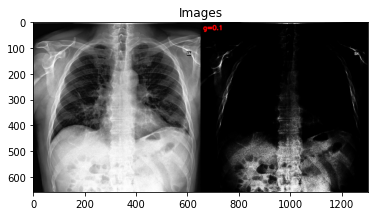

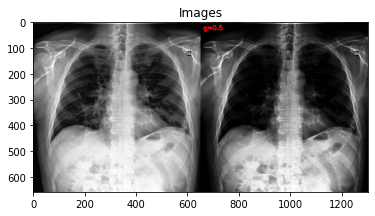

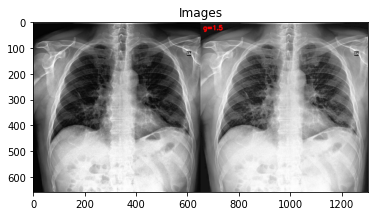

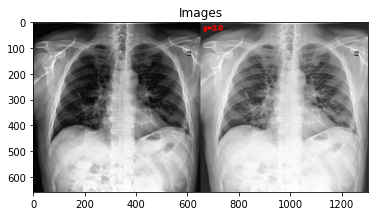

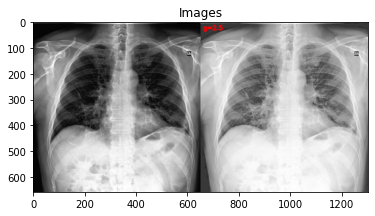

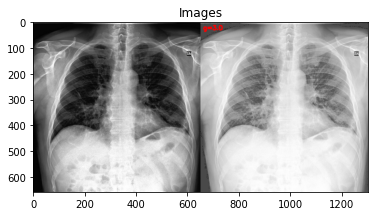

In [22]:
# load the original image
original = cv2.imread(args["image"])

# loop over various values of gamma
for gamma in np.arange(0.0, 3.5, 0.5):
	# ignore when gamma is 1 (there will be no change to the image)
	if gamma == 1:
		continue

	# apply gamma correction and show the images
	gamma = gamma if gamma > 0 else 0.1
	adjusted = adjust_gamma(original, gamma=gamma)
	cv2.putText(adjusted, "g={}".format(gamma), (10, 30),
		cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 3)
	plt_imshow("Images", np.hstack([original, adjusted]))